## Data Processing - Large Dataset (10y)
includes: loading, preprocessing and storing to disk (climatology stats as well)

### Imports

In [1]:
from downscaling.pipeline import DownscalingPipeline
from IPython.display import display
import tensorflow as tf
import os
import xarray as xr

from utility.utility import store_to_disk, load_via_url

%reload_ext autoreload
%autoreload 2

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config=config)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# by using this => it does work, the model runs! :D

### Settings

In [7]:
normalization_type = 'standardized_anomalies'
#normalization_type = 'min_max'

data_path = './data/'
result_path=('./results/')

era5_file = f'era5'
era5_lsm_z_file = f'era5_lsm_z'

cerra_file = f'cerra'
cerra_lsm_orog_file = f'cerra_lsm_orog'

### URLS

In [ ]:
cerra =[
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201001_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201002_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201003_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201004_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201005_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201006_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201007_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201008_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201009_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201010_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201011_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201012_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201101_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201102_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201103_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201104_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201105_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201106_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201107_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201108_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201109_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201110_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201111_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201112_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201201_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201202_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201203_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201204_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201205_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201206_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201207_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201208_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201209_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201210_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201211_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201212_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201301_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201302_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201303_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201304_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201305_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201306_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201307_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201308_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201309_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201310_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201311_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201312_005deg.nc',

    'http://rheissenberger.com/bac/cerra/t2m_cerra_201401_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201402_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201403_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201404_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201405_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201406_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201407_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201408_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201409_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201410_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201411_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201412_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201501_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201502_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201503_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201504_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201505_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201506_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201507_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201508_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201509_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201510_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201511_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201512_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201601_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201602_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201603_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201604_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201605_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201606_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201607_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201608_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201609_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201610_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201611_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201612_005deg.nc',
    
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201701_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201702_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201703_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201704_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201705_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201706_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201707_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201708_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201709_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201710_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201711_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201712_005deg.nc',

    'http://rheissenberger.com/bac/cerra/t2m_cerra_201801_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201802_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201803_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201804_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201805_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201806_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201807_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201808_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201809_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201810_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201811_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201812_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201901_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201902_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201903_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201904_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201905_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201906_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201907_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201908_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201909_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201910_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201911_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_201912_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202001_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202002_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202003_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202004_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202005_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202006_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202007_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202008_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202009_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202010_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202011_005deg.nc',
    'http://rheissenberger.com/bac/cerra/t2m_cerra_202012_005deg.nc'
    ]

era5_add = [
    'http://rheissenberger.com/bac/era5/t2m_era5_lsm_geop_201801_025deg.nc'
]
cerra_add = [
    'http://rheissenberger.com/bac/cerra/t2m_cerra_lsm_orog_201801_005deg.nc'
]

era5 = [    
    'http://rheissenberger.com/bac/era5/t2m_era5_201001_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201002_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201003_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201004_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201005_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201006_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201007_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201008_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201009_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201010_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201011_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201012_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201101_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201102_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201103_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201104_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201105_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201106_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201107_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201108_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201109_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201110_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201111_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201112_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201201_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201202_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201203_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201204_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201205_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201206_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201207_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201208_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201209_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201210_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201211_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201212_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201301_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201302_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201303_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201304_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201305_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201306_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201307_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201308_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201309_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201310_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201311_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201312_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201401_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201402_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201403_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201404_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201405_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201406_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201407_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201408_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201409_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201410_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201411_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201412_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201501_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201502_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201503_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201504_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201505_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201506_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201507_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201508_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201509_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201510_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201511_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201512_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201601_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201602_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201603_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201604_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201605_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201606_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201607_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201608_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201609_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201610_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201611_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201612_025deg.nc',
    
    'http://rheissenberger.com/bac/era5/t2m_era5_201701_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201702_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201703_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201704_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201705_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201706_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201707_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201708_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201709_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201710_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201711_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201712_025deg.nc',

    'http://rheissenberger.com/bac/era5/t2m_era5_201801_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201802_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201803_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201804_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201805_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201806_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201807_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201808_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201809_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201810_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201811_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201812_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201901_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201902_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201903_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201904_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201905_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201906_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201907_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201908_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201909_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201910_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201911_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_201912_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202001_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202002_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202003_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202004_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202005_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202006_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202007_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202008_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202009_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202010_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202011_025deg.nc',
    'http://rheissenberger.com/bac/era5/t2m_era5_202012_025deg.nc'
    ]

### Code to Load via URL

In [ ]:
era5_add_ds = load_via_url(era5_add)
store_to_disk(era5_lsm_z_file, era5_add_ds, data_path)

cerra_add_ds = load_via_url(cerra_add)
store_to_disk(cerra_lsm_orog_file, cerra_add_ds, data_path)

In [ ]:
idx_era5 = 0

for url in era5:
  era5_ds = load_via_url([url])
  store_to_disk("era50"+str(idx_era5), era5_ds, data_path)
  idx_era5+=1


In [ ]:
idx_cerra = 50
for url in cerra[idx_cerra:]:
    cerra_ds = load_via_url([url])
    store_to_disk("cerra0"+str(idx_cerra), cerra_ds, data_path)
    idx_cerra+=1


##### Delete stuff i don't need any more

In [ ]:
del cerra
del cerra_add
del era5
del era5_add
del cerra_ds

### Load from Disk if already stored

In [8]:
era5_add_ds = xr.open_dataset(data_path+era5_lsm_z_file+".nc")
cerra_add_ds = xr.open_dataset(data_path+cerra_lsm_orog_file+".nc")

### Concat Cerra Data
This step is always needed, as the cerra data have been stored to disk as individual files.

In [9]:
idx_era5 =131
start = 0
idx_cerra = idx_era5

In [10]:
# Create a list of file paths
file_paths = [os.path.join(data_path, f'cerra0{i}.nc') for i in range(start, idx_cerra)]

# Open multiple files using open_mfdataset
cerra_ds = xr.open_mfdataset(file_paths)#, concat_dim='time')

# Get the size in bytes
size_in_bytes = cerra_ds.nbytes
size_in_gb = size_in_bytes / (1024**3)  # 1 GB = 1024^3 bytes

print(f"Size of the xarray dataset: {size_in_gb:.2f} GB")

display(cerra_ds)



Size of the xarray dataset: 47.68 GB


<xarray.Dataset>
Dimensions:    (longitude: 801, latitude: 501, time: 31896)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.95 -9.9 -9.85 ... 29.9 29.95 30.0
  * latitude   (latitude) float32 60.0 59.95 59.9 59.85 ... 35.1 35.05 35.0
  * time       (time) datetime64[ns] 2010-01-01 ... 2020-11-30T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 501, 801), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-26 08:08:17 GMT by grib_to_netcdf-2.28.0: grib_to_n...

In [11]:
# Create a list of file paths
file_paths = [os.path.join(data_path, f'era50{i}.nc') for i in range(start, idx_era5)]

# Open multiple files using open_mfdataset
era5_ds = xr.open_mfdataset(file_paths)#, concat_dim='time')

# Get the size in bytes
size_in_bytes = era5_ds.nbytes
size_in_gb = size_in_bytes / (1024**3)  # 1 GB = 1024^3 bytes

print(f"Size of the xarray dataset: {size_in_gb:.2f} GB")

display(era5_ds)


Size of the xarray dataset: 7.38 GB


<xarray.Dataset>
Dimensions:    (longitude: 281, latitude: 221, time: 31896)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 20.5 20.25 20.0
  * time       (time) datetime64[ns] 2010-01-01 ... 2020-11-30T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 221, 281), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-26 07:06:17 GMT by grib_to_netcdf-2.28.0: grib_to_n...

#### Experimenting

In [ ]:
from visualization.evaluation_visualizer import EvaluationVisualization
from preprocessor.preprocessor import extract_t2m_at_specific_times, sort_ds
from downscaling.pipeline import DownscalingPipeline
from visualization.spatial_area_visualizer import SpatialVisualizer

cerra = sort_ds(cerra_ds)
era5 = sort_ds(era5_ds)
era5_add = sort_ds(era5_add_ds)
cerra_add = sort_ds(cerra_add_ds)

cerra = extract_t2m_at_specific_times(cerra)
era5 = extract_t2m_at_specific_times(era5)

lon_min = 8.3
lat_min = 43.8
lon_max = 14.5
lat_max = 51.5

crop_area = [lon_min, lat_min, lon_max, lat_max]


cerra = cerra.sel(
            longitude=slice(crop_area[0], crop_area[2]),
            latitude=slice(crop_area[1], crop_area[3])
        )

era5 = era5.sel(
            longitude=slice(crop_area[0], crop_area[2]),
            latitude=slice(crop_area[1], crop_area[3])
        )

era5_add = era5_add.sel(
            longitude=slice(crop_area[0], crop_area[2]),
            latitude=slice(crop_area[1], crop_area[3])
        )

cerra_add = cerra_add.sel(
            longitude=slice(crop_area[0], crop_area[2]),
            latitude=slice(crop_area[1], crop_area[3])
        )

#ecv = EvaluationVisualization()
# Assuming hr_data is your high-resolution data
#ecv.histograms(cerra, era5, 'High-Resolution Data')

print(era5)

c = SpatialVisualizer(era5)
c.visualize_spatial_area()


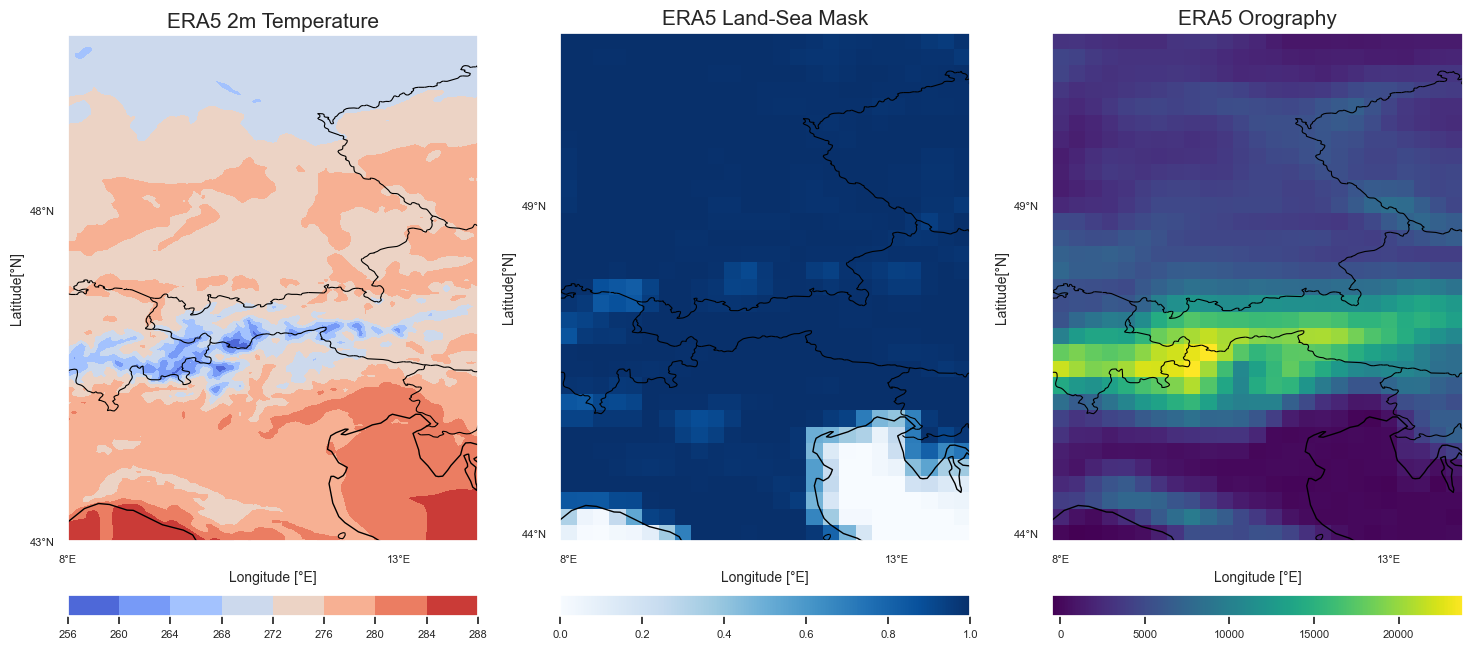

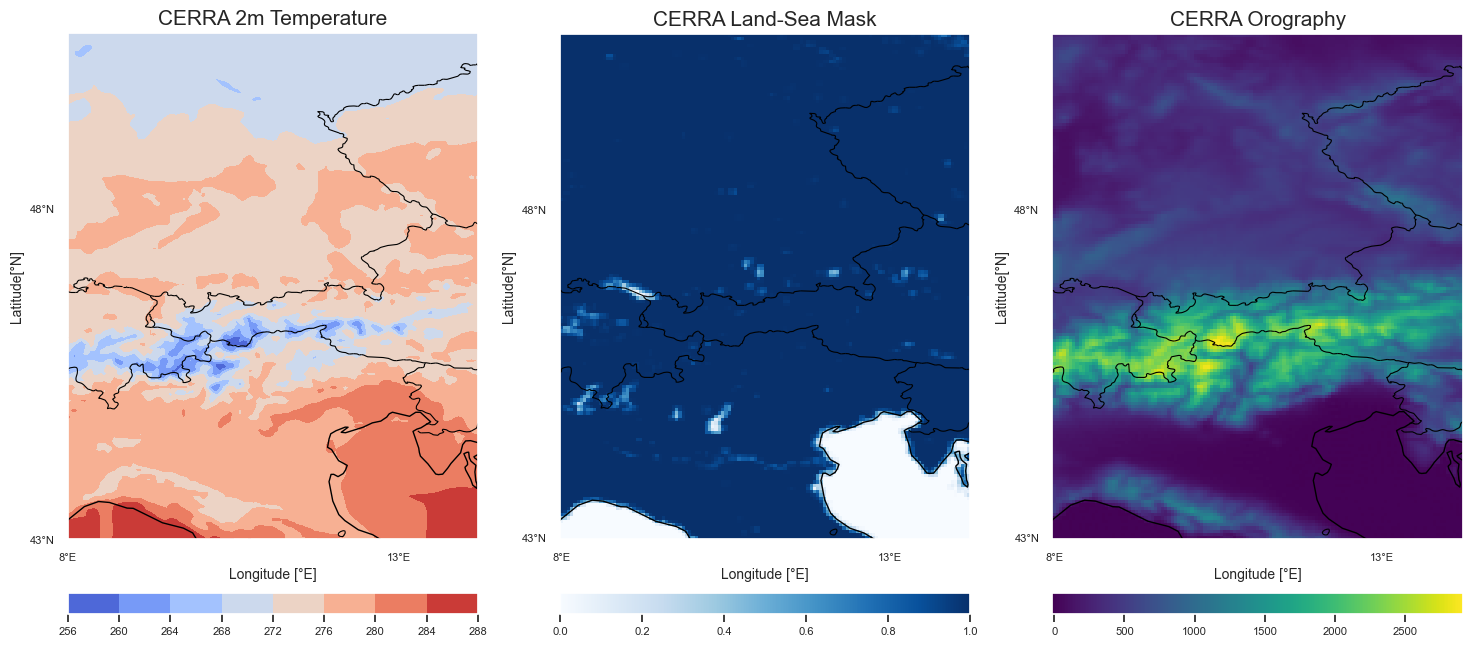

In [11]:
from visualization.climate_data_visualizer import ClimateDataVisualizer
map_visualizer = ClimateDataVisualizer()
map_visualizer.plot_climate_data(cerra, era5_add, cerra, cerra_add)

In [ ]:
import numpy as np
from scipy import stats

def get_stats_and_outliers(data):
  """
  Gets descriptive statistics and checks for outliers in the 't2m' variable of an xarray.Dataset.

  Args:
      data: An xarray.Dataset containing the 't2m' variable.

  Returns:
      A dictionary containing:
          stats: A dictionary with descriptive statistics of the 't2m' data.
          is_outlier: A boolean numpy array indicating outliers (True) and inliers (False).
          outlier_indices: A list of indices of the identified outliers.
  """
  # Extract the 't2m' data as a NumPy array
  t2m_data = data['t2m'].to_numpy()

  # Calculate descriptive statistics
  stats = {
      'total_numer': len(t2m_data),
      'min': np.min(t2m_data),
      'max': np.max(t2m_data),
      'mean': np.mean(t2m_data),
      'median': np.median(t2m_data),
      'std': np.std(t2m_data),
      'q1': np.percentile(t2m_data, 25),
      'q3': np.percentile(t2m_data, 75),
      'iqr': np.percentile(t2m_data, 75) - np.percentile(t2m_data, 25),
  }

  # Check for outliers using IQR (more robust for skewed data)
  is_outlier, outlier_indices = check_outliers(t2m_data, method='iqr')

  return stats, is_outlier, outlier_indices

def check_outliers(data, method='iqr'):
  """
  Checks for outliers in data using the specified method.

  Args:
      data: A numpy array containing the data.
      method (str, optional): The method to use for outlier detection. 
                              Options include 'iqr' (Interquartile range) and 'zscore' (Z-scores).
                              Defaults to 'iqr'.

  Returns:
      A tuple containing:
          is_outlier: A boolean numpy array indicating outliers (True) and inliers (False).
          outlier_indices: A list of indices of the identified outliers.
  """
  if method == 'iqr':
    # Use Interquartile Range (IQR) for outlier detection
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    is_outlier = (data < lower_bound) | (data > upper_bound)
    outlier_indices = np.where(is_outlier)[0].tolist()
  elif method == 'zscore':
    # Use Z-scores for outlier detection (might not be suitable for skewed data)
    z_scores = stats.zscore(data)
    threshold = 3  # Consider values outside 3 standard deviations as outliers
    is_outlier = np.abs(z_scores) > threshold
    outlier_indices = np.where(is_outlier)[0].tolist()
  else:
    raise ValueError("Invalid method. Choose from 'iqr' or 'zscore'.")
  return is_outlier, outlier_indices

# Get stats and outliers for lr data
lr_stats, lr_outliers, lr_outlier_indices = get_stats_and_outliers(combined_anomalies_lr_data)

# Get stats and outliers for hr data
hr_stats, hr_outliers, hr_outlier_indices = get_stats_and_outliers(anomalies_hr_data)

# Print results (example)
print("LR data:")
for key, value in lr_stats.items():
  print(f"{key}: {value}")

print("Number of outliers:", len(lr_outlier_indices))
print("Outlier indices:", lr_outlier_indices)

print("\nHR data:")
for key, value in hr_stats.items():
  print(f"{key}: {value}")
print("Number of outliers:", len(hr_outlier_indices))
print("Outlier indices:", hr_outlier_indices)


In [ ]:
p = DownscalingPipeline()
combined_anomalies_lr_data, anomalies_hr_data = p.preprocess_data(cerra_ds, era5_ds, era5_add_ds, cerra_add_ds, crop_region=crop_area)
ecv.histograms(anomalies_hr_data, combined_anomalies_lr_data, 'High-Resolution Data')

print(combined_anomalies_lr_data)
print(anomalies_hr_data)

In [ ]:
p = DownscalingPipeline()
combined_anomalies_lr_data, anomalies_hr_data = p.preprocess_data(cerra_ds, era5_ds, era5_add_ds, cerra_add_ds, crop_region=crop_area)
ecv.histograms(anomalies_hr_data, combined_anomalies_lr_data, 'High-Resolution Data')

display(combined_anomalies_lr_data, anomalies_hr_data)

#### Preprocess Data

In [12]:
#lon_min = 6.5
#lat_min = 44
#lon_max = 15.5
#lat_max = 54

lon_min = 8.3
lat_min = 43.8
lon_max = 14.5
lat_max = 51.5

crop_area = [lon_min, lat_min, lon_max, lat_max]

stats_file = './config/climatology_stats_sa_10y.json'

In [13]:
pipeline = DownscalingPipeline(normalization_type)

preprocessed_lr_data, preprocessed_hr_data = pipeline.preprocess_data(era5_ds, cerra_ds, era5_add_ds, cerra_add_ds, crop_region=crop_area, stats_filename=stats_file)

In [14]:
display(preprocessed_lr_data)
display(preprocessed_hr_data)

<xarray.Dataset>
Dimensions:    (longitude: 96, latitude: 128, time: 3987)
Coordinates:
  * longitude  (longitude) float32 9.0 9.05 9.1 9.15 ... 13.6 13.65 13.7 13.75
  * latitude   (latitude) float32 44.5 44.55 44.6 44.65 ... 50.75 50.8 50.85
  * time       (time) datetime64[ns] 2010-01-01T12:00:00 ... 2020-11-30T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 -1.378 -1.353 ... -1.121
    lsm        (time, latitude, longitude) float32 -0.4848 -0.4258 ... 0.2752
    z          (time, latitude, longitude) float32 -0.2839 -0.224 ... -0.293
Attributes:
    units:      K
    long_name:  2 metre temperature

<xarray.Dataset>
Dimensions:    (time: 3987, latitude: 128, longitude: 96)
Coordinates:
  * longitude  (longitude) float32 9.0 9.05 9.1 9.15 ... 13.6 13.65 13.7 13.75
  * latitude   (latitude) float32 44.5 44.55 44.6 44.65 ... 50.75 50.8 50.85
  * time       (time) datetime64[ns] 2010-01-01T12:00:00 ... 2020-11-30T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 -1.475 -1.338 ... -1.183
Attributes:
    units:      K
    long_name:  2 metre temperature

#### Store preprocessed data
To avoid repeating the preprocessing steps every time to train the model.

In [15]:
era5_preprocessed_file = f'era5_preprocessed_{normalization_type}_10y'
cerra_preprocessed_file = f'cerra_preprocessed_{normalization_type}_10y'

store_to_disk(era5_preprocessed_file, preprocessed_lr_data, data_path)
store_to_disk(cerra_preprocessed_file, preprocessed_hr_data, data_path)

Writing to ./data/era5_preprocessed_standardized_anomalies_10y.nc
Writing to ./data/cerra_preprocessed_standardized_anomalies_10y.nc


In [16]:
from utility.utility import split_data

lr_train_data, lr_val_data, lr_test_data, hr_train_data, hr_val_data, hr_test_data = split_data(preprocessed_lr_data, preprocessed_hr_data)

train_data = [lr_train_data, hr_train_data]
val_data = [lr_val_data, hr_val_data]
test_data = [lr_test_data, hr_test_data]

data_path = './data_split/'

store_to_disk('lr_train_sa_10y', lr_train_data, data_path)
store_to_disk('hr_train_sa_10y', hr_train_data, data_path)

store_to_disk('lr_val_sa_10y', lr_val_data, data_path)
store_to_disk('hr_val_sa_10y', hr_val_data, data_path)

store_to_disk('lr_test_sa_10y', lr_test_data, data_path)
store_to_disk('hr_test_sa_10y', hr_test_data, data_path)

Writing to ./data_split/lr_train_sa_10y.nc
Writing to ./data_split/hr_train_sa_10y.nc
Writing to ./data_split/lr_val_sa_10y.nc
Writing to ./data_split/hr_val_sa_10y.nc
Writing to ./data_split/lr_test_sa_10y.nc
Writing to ./data_split/hr_test_sa_10y.nc
